# Paths and imports

In [2]:
# imports
import json
from pathlib import Path
import os
import sys

# Paths to preprocessed datasets, generated by utils/prep.py (to speed up evaluation)
DIR_DATASET = Path(current_dir=os.getcwd()).parent.absolute()/'dataset_DocRED'
DATA_DEV = DIR_DATASET/'dev.json' 
DATA_TRAIN = DIR_DATASET/'train_annotated.json'
DATA_TEST = DIR_DATASET/'test.json'

DIR_DATASET_PREP = Path(current_dir=os.getcwd()).parent.absolute()/'dataset_prep'
DATA_DEV_PREP = DIR_DATASET_PREP/'dev_prep.pickle' 
DATA_TRAIN_PREP = DIR_DATASET_PREP/'train_annotated_prep.pickle'

PATH_UTILS = DIR_DATASET.parent.absolute().__str__()

# add local lib to path
if PATH_UTILS not in sys.path:
    sys.path.append(PATH_UTILS)

C:\Users\chira\AppData\Local\Temp\ipykernel_11792\74253620.py:8: DeprecationWarning: support for supplying keyword arguments to pathlib.PurePath is deprecated and scheduled for removal in Python 3.14
  DIR_DATASET = Path(current_dir=os.getcwd()).parent.absolute()/'dataset_DocRED'
C:\Users\chira\AppData\Local\Temp\ipykernel_11792\74253620.py:13: DeprecationWarning: support for supplying keyword arguments to pathlib.PurePath is deprecated and scheduled for removal in Python 3.14
  DIR_DATASET_PREP = Path(current_dir=os.getcwd()).parent.absolute()/'dataset_prep'


# Load Dataset

In [3]:
import pickle
# load eval and test dataset
fData = open(DATA_DEV_PREP.__str__(), 'rb')
data_eval = pickle.load(fData)
fData.close()

fData = open(DATA_DEV.__str__(), 'r', encoding='utf-8')
data_eval_raw = json.load(fData)
fData.close()

fData = open(DATA_TEST.__str__(), 'r', encoding='utf-8')
data_test_raw = json.load(fData)
fData.close()

# load in dataset metadata
fN2id = open(DIR_DATASET/'DocRED_baseline_metadata'/'ner2id.json', 'r', encoding='utf-8')
fR2id = open(DIR_DATASET/'DocRED_baseline_metadata'/'rel2id.json', 'r', encoding='utf-8')
fR2info = open(DIR_DATASET/'rel_info.json', 'r', encoding='utf-8')
n2id = json.load(fN2id)
fN2id.close()
r2id = json.load(fR2id)
fR2id.close()
r2info = json.load(fR2info)
fR2id.close()

# metadata mappings
id2n = {value: key for key, value in n2id.items()}
id2r = {value: key for key, value in r2id.items()}

# Model Evaluation

## Visualize Training/Validation Loss

lowest training loss: epoch 50
lowest validation loss: epoch 30


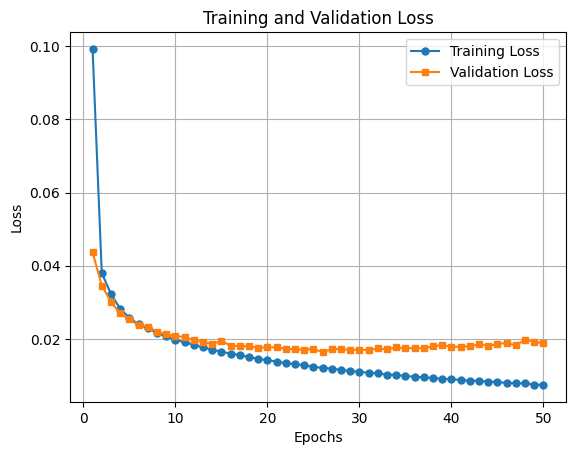

In [4]:
import numpy as np

# load save train and validation loss
loss_train = np.load('checkpoints/loss_train.npy')
loss_val = np.load('checkpoints/loss_val.npy')

loss_train_cp = [loss_train[i] for i in range(5-1, 50, 5)]
loss_val_cp = [loss_val[i] for i in range(5-1, 50, 5)]

print(f"lowest training loss: epoch {(np.argmin(loss_train_cp) + 1) * 5}")
print(f"lowest validation loss: epoch {(np.argmin(loss_val_cp) + 1) * 5}")

from matplotlib import pyplot as plt
epochs = np.arange(1, len(loss_train) + 1)
plt.plot(epochs, loss_train, label="Training Loss", marker='o', markersize=5)
plt.plot(epochs, loss_val, label="Validation Loss", marker='s', markersize=5)


# Formatting
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

## Load Model Checkpoint

In [5]:
# Define & load model
import torch
from torch import nn
from transformers import AutoTokenizer, DistilBertModel 
from pytorch_tcn import TemporalConv1d

# HERE, define the path to the model checkpoint
MODEL_STATE_BEST = Path(current_dir=os.getcwd()).parent.absolute()/'checkpoints'/'lstm_tcn_50e.model'
MODEL_STATE = MODEL_STATE_BEST
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# TCN block
class TCN_Block(nn.Module):
    def __init__(self, in_features, out_features, kernel_size=7, stride=1, dilation=1, dropout=0.3):
        super(TCN_Block, self).__init__()

        # temporal conv with weight_norm
        self.res = nn.Conv1d(in_features, out_features, kernel_size=1) # 1x1 conv sampling for residual
        self.conv = nn.utils.parametrizations.weight_norm(TemporalConv1d(in_features, out_features, kernel_size, stride, dilation=dilation))
        self.relu = nn.ReLU() 
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = self.conv(x) # Dilated Causal Conv
        x = self.dropout(self.relu(x)) # dropout regularization
        return x

# The model
class LSTM_TCNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, hidden_dims_tcn, dropout=0.3):
        super(LSTM_TCNClassifier, self).__init__()
        self.coref_embed = nn.Embedding(512, 20, padding_idx=0)
        self.ner_embed = nn.Embedding(512, 20, padding_idx=0)

        # tcn
        tcn_layers = []
        for i in range(len(hidden_dims_tcn)):
            in_features = 0
            if i == 0:
                in_features = input_dim
            else:
                in_features = hidden_dims_tcn[i-1]
            out_features = hidden_dims_tcn[i]
            dilation = 2 ** i # dilation 1, 2, 4, ...
            tcn_layer = TCN_Block(in_features, out_features, dilation=dilation, dropout=dropout)
            tcn_layers.append(tcn_layer)
        self.tcn = nn.Sequential(*tcn_layers)

        # lstm
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)

        # layer norms
        self.ln_h = nn.LayerNorm(hidden_dim)
        self.ln_t = nn.LayerNorm(hidden_dim)

        # classification
        self.dropout1 = nn.Dropout(p=dropout)
        self.fc1 = nn.Linear(hidden_dim+hidden_dims_tcn[-1], hidden_dim)
        self.relu1 = nn.ReLU()

        # bilinear output
        self.bln = nn.Bilinear(hidden_dim*2, hidden_dim*2, output_dim)

        # self.softmax = nn.Softmax(dim=-1) # NOTE: removed, output bilinear, use sigmoid later

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
    
    def forward(self, embed, coref, ner, map_h, map_t):
        # coref 
        coref = self.coref_embed(coref)
        # ner (coref_type)
        ner = self.ner_embed(ner)
        
        net_in = torch.cat([embed, coref, ner], dim=-1)

        # tcn
        tcn_out = self.tcn(net_in.transpose(-1, -2)).transpose(-1, -2)

        # lstm
        hidden, carry = torch.zeros(self.num_layers, net_in.shape[0], self.hidden_dim).to(embed.device), torch.zeros(self.num_layers, net_in.shape[0], self.hidden_dim).to(embed.device)
        # xavier init hidden and carry for stability over randn
        nn.init.xavier_normal_(hidden)
        nn.init.xavier_normal_(carry)
        lstm_out, (hidden, carry) = self.lstm(net_in, (hidden, carry))


        # Extract features from time sequence output

        # concat tcn and lstm features
        seq_out = torch.cat([tcn_out, lstm_out], dim=-1)
        # linear layer
        seq_out = self.dropout1(self.relu1(self.fc1(seq_out)))

        # saperate features for head and tail entities
        map_h = map_h.float().unsqueeze(1)
        map_t = map_t.float().unsqueeze(1)

        seq_out_h = self.ln_h(torch.matmul(map_h, seq_out).squeeze(1)) 
        seq_out_t = self.ln_t(torch.matmul(map_t, seq_out).squeeze(1))

        dist = seq_out_t - seq_out_h

        seq_out_h = torch.concat([seq_out_h, dist], dim=-1)
        seq_out_t = torch.concat([seq_out_t, -dist], dim=-1)
        
        # bilinear output
        out = self.bln(seq_out_h, seq_out_t)
        return out

# Parameters
input_dim = 768 + 20 + 20  # DistilledBERT pretrained embeddings + coref + ner type (both head and tail)
hidden_dim = 128
hidden_dims_tcn=[256,128,64]
dropout = 0.3
output_dim = 96 + 1  # 96 types + Na
num_layers = 2
batch_size = 64


# load tokenizer & embeddings
tokenizer = AutoTokenizer.from_pretrained('distilbert/distilbert-base-uncased')
# flash_attention2 requires compiling cuda kernel from source which takes a long time, for inference use spda implementation for out-of-box compatability
# model_embed = DistilBertModel.from_pretrained("distilbert/distilbert-base-uncased", torch_dtype=torch.float16, attn_implementation="flash_attention_2", device_map="cuda:0")
model_embed = DistilBertModel.from_pretrained("distilbert/distilbert-base-uncased", torch_dtype=torch.float16, attn_implementation="sdpa")
model_embed = model_embed.to(device)

# load model
model = LSTM_TCNClassifier(input_dim, hidden_dim, output_dim, num_layers, hidden_dims_tcn=hidden_dims_tcn, dropout=dropout).to(device)
model.load_state_dict(torch.load(MODEL_STATE, weights_only=True))
model.eval() # turn off dropout, etc.

C:\Users\chira\AppData\Local\Temp\ipykernel_11792\1982784334.py:8: DeprecationWarning: support for supplying keyword arguments to pathlib.PurePath is deprecated and scheduled for removal in Python 3.14
  MODEL_STATE_BEST = Path(current_dir=os.getcwd()).parent.absolute()/'checkpoints'/'lstm_tcn_50e.model'


LSTM_TCNClassifier(
  (coref_embed): Embedding(512, 20, padding_idx=0)
  (ner_embed): Embedding(512, 20, padding_idx=0)
  (tcn): Sequential(
    (0): TCN_Block(
      (res): Conv1d(808, 256, kernel_size=(1,), stride=(1,))
      (conv): ParametrizedTemporalConv1d(
        808, 256, kernel_size=(7,), stride=(1,)
        (padder): ConstantPad1d(padding=(6, 0), value=0.0)
        (parametrizations): ModuleDict(
          (weight): ParametrizationList(
            (0): _WeightNorm()
          )
        )
      )
      (relu): ReLU()
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (1): TCN_Block(
      (res): Conv1d(256, 128, kernel_size=(1,), stride=(1,))
      (conv): ParametrizedTemporalConv1d(
        256, 128, kernel_size=(7,), stride=(1,), dilation=(2,)
        (padder): ConstantPad1d(padding=(12, 0), value=0.0)
        (parametrizations): ModuleDict(
          (weight): ParametrizationList(
            (0): _WeightNorm()
          )
        )
      )
      (relu): ReLU()
    

## Evaluation Metrics (Precision, Recall, F1)

In [6]:
from tqdm import tqdm
from torch.nn import Sigmoid
from itertools import chain

criterion = nn.BCEWithLogitsLoss()
sigmoid = Sigmoid()
class_threshold = 0.0

# counts for eval metrics
tp = 0
total_rel = 0
total_pred = 0

for idx, doc in enumerate(data_eval):
    sents = doc['sents']
    ebd = doc['embed'].unsqueeze(0).to(device)
    rs = doc['rs']
    refs = doc['ner_ref']
    ners = doc['ner_set']
    labels = doc['rs']
    
    # predicted relations
    preds = []
    # iterate through labels to compute eval metrics
    for label in labels:
        idx_h = label['h']
        idx_t = label['t']
        ref_h, ref_h_type = refs[idx_h]
        ref_t, ref_t_type = refs[idx_t]
        coref = (ref_h + ref_t)
        coref_type = (ref_h_type + ref_t_type)
        pad_size = ebd.shape[0] - coref.shape[0]
        coref_padded, coref_type_padded = coref, coref_type
        if pad_size > 0:
            coref_padded = torch.cat([coref, torch.zeros(pad_size, coref.shape[1])], dim=0)
            coref_type_padded = torch.cat([coref_type, torch.zeros(pad_size, coref_type.shape[1])], dim=0)
            ref_h = torch.cat([ref_h, torch.zeros(pad_size, coref_type.shape[1])], dim=0)
            ref_t = torch.cat([ref_t, torch.zeros(pad_size, coref_type.shape[1])], dim=0)

        # dirty quick fix for unbatched input error with pytorch lstm
        coref_padded = coref_padded.unsqueeze(0).squeeze(-1).long().to(device)
        coref_type_padded = coref_type_padded.unsqueeze(0).squeeze(-1).long().to(device)
        ref_h = ref_h.unsqueeze(0).squeeze(-1).to(device)
        ref_t = ref_t.unsqueeze(0).squeeze(-1).to(device)

        with torch.no_grad():
            pred = sigmoid(model(ebd, coref_padded, coref_type_padded, ref_h, ref_t)).cpu().squeeze(0)

        idx_type = torch.argmax(pred).item()
        if pred[idx_type].sum() < class_threshold:
            continue
        if idx_type == 0:
            continue
        preds.append((idx_h, idx_t, idx_type))

    # ground truth (labels) 
    gt = []
    for label in labels:
        idx_h = label['h']
        idx_t = label['t']
        idx_type = torch.argmax(label['r']).cpu().item()
        gt.append((idx_h, idx_t, idx_type))

    # count true positives
    for label in gt:
        # if label correctly predicted (TP)
        if label in preds:
            tp += 1

    total_rel += len(labels)
    total_pred += len(preds)


# Compute PR and F1
precision = tp/total_pred
recall = tp/total_rel
f1 = 2 * precision * recall / (precision + recall)

print(f"precision={precision}, recall={recall}, f1={f1}")


precision=0.6436242216406461, recall=0.5810183299389002, f1=0.6107210138722384


30e - precision=0.6403186823023901, recall=0.5827291242362526, f1=0.6101680457220847
50e - precision=0.6436242216406461, recall=0.5810183299389002, f1=0.6107210138722384

## Model Inference Demo (Relation Extraction)

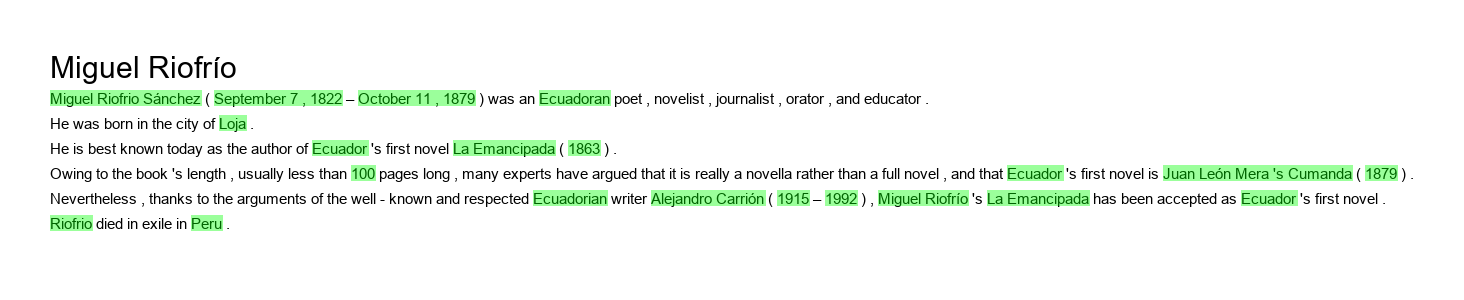

In [9]:
# load demo document (in DocRED's format, with NER labels)
# doc = {"vertexSet": [[{"pos": [1, 5], "type": "ORG", "sent_id": 1, "name": "Ministry for Home Security"}, {"name": "Ministry of Home Security", "pos": [1, 5], "sent_id": 0, "type": "ORG"}, {"name": "Ministry", "pos": [1, 2], "sent_id": 2, "type": "ORG"}, {"pos": [1, 2], "type": "ORG", "sent_id": 4, "name": "Ministry"}, {"pos": [7, 8], "type": "ORG", "sent_id": 7, "name": "Ministry"}], [{"name": "British", "pos": [7, 8], "sent_id": 0, "type": "LOC"}], [{"pos": [12, 13], "type": "TIME", "sent_id": 0, "name": "1939"}], [{"name": "Second World War", "pos": [29, 32], "sent_id": 0, "type": "MISC"}], [{"name": "John Anderson", "pos": [9, 11], "sent_id": 1, "type": "PER"}, {"name": "John Anderson", "pos": [5, 7], "sent_id": 6, "type": "PER"}], [{"pos": [27, 31], "type": "ORG", "sent_id": 2, "name": "Women \u2019s Voluntary Service"}], [{"sent_id": 3, "type": "ORG", "pos": [9, 10], "name": "ARP"}], [{"pos": [9, 11], "type": "ORG", "sent_id": 4, "name": "Home Office"}], [{"pos": [28, 30], "type": "ORG", "sent_id": 5, "name": "Fire Guards"}], [{"pos": [1, 3], "type": "TIME", "sent_id": 6, "name": "October 1940"}], [{"name": "Herbert Morrison", "pos": [10, 12], "sent_id": 6, "type": "PER"}], [{"pos": [17, 19], "type": "PER", "sent_id": 6, "name": "Neville Chamberlain"}], [{"pos": [2, 3], "type": "ORG", "sent_id": 7, "name": "Allied"}], [{"name": "Europe", "pos": [5, 6], "sent_id": 7, "type": "LOC"}], [{"pos": [11, 13], "type": "TIME", "sent_id": 7, "name": "May 1945"}]], "labels": [{"r": "P571", "h": 0, "t": 2, "evidence": [0]}, {"r": "P576", "h": 0, "t": 14, "evidence": [7]}, {"r": "P607", "h": 4, "t": 3, "evidence": [0, 1]}, {"r": "P27", "h": 4, "t": 1, "evidence": [0, 1]}, {"r": "P607", "h": 10, "t": 3, "evidence": [0, 6]}, {"r": "P27", "h": 10, "t": 1, "evidence": [0, 6]}, {"r": "P30", "h": 1, "t": 13, "evidence": [0, 7]}, {"r": "P607", "h": 11, "t": 3, "evidence": [0, 6]}, {"r": "P27", "h": 11, "t": 1, "evidence": [0, 6]}, {"r": "P17", "h": 7, "t": 1, "evidence": [0, 4]}, {"r": "P276", "h": 3, "t": 13, "evidence": [0, 7]}], "title": "Ministry of Home Security", "sents": [["The", "Ministry", "of", "Home", "Security", "was", "a", "British", "government", "department", "established", "in", "1939", "to", "direct", "national", "civil", "defence", "(", "primarily", "tasked", "with", "organising", "air", "raid", "precautions", ")", "during", "the", "Second", "World", "War", "."], ["The", "Ministry", "for", "Home", "Security", "was", "headed", "by", "Sir", "John", "Anderson", "the", "Home", "Secretary", "and", "Minister", "of", "Home", "Security", "."], ["The", "Ministry", "'s", "responsibilities", "covered", "all", "central", "and", "regional", "civil", "defence", "organisations", "(", "such", "as", "air", "raid", "wardens", ",", "rescue", "squads", ",", "fire", "services", ",", "and", "the", "Women", "\u2019s", "Voluntary", "Service", ")", "."], ["It", "was", "also", "responsible", "for", "giving", "approval", "to", "local", "ARP", "schemes", ",", "and", "providing", "public", "shelters", "."], ["The", "Ministry", "(", "run", "under", "the", "auspices", "of", "the", "Home", "Office", ")", "produced", "hundreds", "of", "leaflets", "that", "were", "delivered", "to", "the", "population", "advising", "on", "how", "to", "deal", "with", "the", "impending", "air", "raids", "."], ["It", "also", "managed", "propaganda", "poster", "campaigns", "to", "encourage", ",", "amongst", "other", "things", ",", "the", "carrying", "of", "gas", "masks", "and", "for", "volunteers", "to", "join", "civil", "defence", "groups", "like", "the", "Fire", "Guards", "."], ["In", "October", "1940", ",", "Sir", "John", "Anderson", "was", "replaced", "by", "Herbert", "Morrison", "in", "a", "reshuffle", "precipitated", "by", "Neville", "Chamberlain", "'s", "resignation", "due", "to", "ill", "-", "health", "."], ["With", "the", "Allied", "victory", "in", "Europe", "the", "Ministry", "was", "disbanded", "in", "May", "1945", "."]]}
# alternatively, load any example from DocRED test dataset (no relation labels, only NER as part of model input)
doc = data_test_raw[0]

# import document visualization util implemented in utils/vis.py 
from utils import vis_text
img = vis_text(doc)
img

In [10]:
# pre-processing 
sents = None # Text
embed = None # Text embeddings
ner = [] # named entities
ner_ref = [] # named entitiy references, tuple(pos, type)
ner_set = [] # named entitiy set, tuple(name, type)
class_threshold = 0.9 # hyperparameter to adjust classification decision boundary, below whih whill be classified as no relation, may improve precision but lower recall

# full document text
sentences = list(chain.from_iterable(doc['sents'])) # Concatenate sentences 
# embeddings
inputs = tokenizer(sentences, padding=False, truncation=True, return_tensors="pt", is_split_into_words=True, 
                    max_length=512).to(device)
with torch.no_grad():
    outputs = model_embed(**inputs)
embed = outputs.last_hidden_state.to(device)
len_embed = embed.shape[1]

# prep named entity labels
for entities in doc['vertexSet']:
    ner_set.append((entities[0]['name'], entities[0]['type']))
    # NER mentions
    mentions = []
    # foreach type of entity
    for entity in entities:
        # foreach entity instance
        idx_start, idx_end = entity['pos'] 
        idx_sent = entity['sent_id']
        len_before = len(list(chain.from_iterable(doc['sents'][:idx_sent])))
        idx_start += len_before
        idx_end += len_before
        # preped NER label 
        e = {
            'name': entity['name'], 
            'pos': (idx_start, idx_end), 
            'type': n2id[entity['type']]
        }
        mentions.append(e)
    ner.append(mentions)

    # references (NER pos info)
    ref = torch.zeros((len_embed, 1), dtype=torch.float16)
    ref_type = torch.zeros((len_embed, 1), dtype=torch.float16)
    for mention in mentions:
        idx_start, idx_end = mention['pos']
        ref[idx_start:idx_end] = 1.0
        ref_type[idx_start:idx_end] = n2id[entities[0]['type']]
    ner_ref.append((ref, ref_type))

# predict relation from named entities
for idx_h, h in enumerate(ner_set):
    for idx_t, t in enumerate(ner_set):
        if h == t:
            continue
        # pack model input to tensors
        ref_h, ref_h_type = ner_ref[idx_h]
        ref_t, ref_t_type = ner_ref[idx_t]
        coref = (ref_h + ref_t)
        coref_type = (ref_h_type + ref_t_type)
        pad_size = embed.shape[0] - coref.shape[0]
        coref_padded, coref_type_padded = coref, coref_type
        if pad_size > 0:
            coref_padded = torch.cat([coref, torch.zeros(pad_size, coref.shape[1])], dim=0)
            coref_type_padded = torch.cat([coref_type, torch.zeros(pad_size, coref_type.shape[1])], dim=0)
            ref_h = torch.cat([ref_h, torch.zeros(pad_size, coref_type.shape[1])], dim=0)
            ref_t = torch.cat([ref_t, torch.zeros(pad_size, coref_type.shape[1])], dim=0)

        # dirty quick fix for unbatched input error with pytorch lstm
        coref_padded = coref_padded.unsqueeze(0).squeeze(-1).long().to(device)
        coref_type_padded = coref_type_padded.unsqueeze(0).squeeze(-1).long().to(device)
        ref_h = ref_h.unsqueeze(0).squeeze(-1).to(device)
        ref_t = ref_t.unsqueeze(0).squeeze(-1).to(device)

        with torch.no_grad():
            pred = sigmoid(model(embed, coref_padded, coref_type_padded, ref_h, ref_t)).cpu().squeeze(0)

        # get classified realation
        idx_type = torch.argmax(pred).item()

        # decision boundary for no relation
        if pred[idx_type] < class_threshold:
            continue
        if idx_type == 0:
            continue

        # display relation extracted
        name_h = ner_set[idx_h][0]
        name_t = ner_set[idx_t][0]
        rel = r2info[id2r[idx_type]]
        print(f"({name_h} ==<{rel}>==> {name_t}), p={pred[idx_type]}")

(Miguel Riofrio Sánchez ==<date of birth>==> September 7 , 1822), p=1.0
(Miguel Riofrio Sánchez ==<date of death>==> October 11 , 1879), p=0.9999998807907104
(Miguel Riofrio Sánchez ==<country of citizenship>==> Ecuadoran), p=0.9944098591804504
(Miguel Riofrio Sánchez ==<notable work>==> La Emancipada), p=0.9993135929107666
(Miguel Riofrio Sánchez ==<date of birth>==> 1863), p=0.9999810457229614
(Miguel Riofrio Sánchez ==<notable work>==> Juan León Mera 's Cumanda), p=0.9789798259735107
(Miguel Riofrio Sánchez ==<country of citizenship>==> Peru), p=0.9934667944908142
(La Emancipada ==<author>==> Miguel Riofrio Sánchez), p=0.9995433688163757
(La Emancipada ==<country of origin>==> Ecuadoran), p=0.9630987048149109
(La Emancipada ==<publication date>==> 1863), p=0.9958370923995972
(La Emancipada ==<publication date>==> 1879), p=0.9649806618690491
(La Emancipada ==<author>==> Alejandro Carrión), p=0.9127801060676575
(La Emancipada ==<country of origin>==> Peru), p=0.9781658053398132
(Juan 